In [67]:
# Cargar Librerias Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Carga de datos

In [68]:
# Cargar lista de insumos
dir = 'raw_data/'
file = 'files_list.csv'

file_df = pd.read_csv(dir + file, index_col='ind')

#Separar códigos bursátiles
pattern = r'\((.*?)\)'

file_df['stock'] = file_df['name'].str.extract(pattern)
file_df['name'] = file_df['name'].str.replace(pattern, '')

# Seleccionar el top de empresas a usar (siempre cargar negativos y 0)
top_n = 10

file_df = file_df[file_df.index < top_n + 1]
file_df

<ipython-input-68-bda87438d916>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  file_df['name'] = file_df['name'].str.replace(pattern, '')


,name,stock
ind,,
-2,FEDFUNDS,FEDFUNDS
-1,UNRATE,UNRATE
0,NASDAQ 100,^NDX
1,Apple Inc.,AAPL
2,Microsoft Corporation,MSFT
3,"Amazon.com, Inc.",AMZN
4,NVIDIA Corporation,NVDA
5,"Meta Platforms, Inc.",META
6,Broadcom Inc.,AVGO


In [69]:
# Cargar archivos en dataframe y gardarlos en diccionario
stocks_dict = {}

for f in file_df['stock']:
    file = f + '.csv'
    df_name = f + '_DF'
    df = pd.read_csv(dir + file)
    stocks_dict[df_name] = df

stocks_dict.keys()

dict_keys(['FEDFUNDS_DF', 'UNRATE_DF', '^NDX_DF', 'AAPL_DF', 'MSFT_DF', 'AMZN_DF', 'NVDA_DF', 'META_DF', 'AVGO_DF', 'TSLA_DF', 'GOOG_DF', 'GOOGL_DF', 'ADBE_DF'])

# Preprocesado de datos

In [70]:
# Parsear formato de fechas para FEDFUNDS y UNRATE
macros = ['FEDFUNDS_DF', 'UNRATE_DF']
stocks = [key for key in stocks_dict.keys() if key not in macros]

for i in macros:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
    stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')

    # Cambiar nombre de columna a Date
    stocks_dict[i].rename(columns= {'DATE' : 'Date'}, inplace= True)

<ipython-input-70-16430d4a6285>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
<ipython-input-70-16430d4a6285>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')
<ipython-input-70-16430d4a6285>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `d

In [71]:
# Visualización de los dataframe
stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [72]:
# Seleccionar variables que nos interesan y eliminar las demas de los DF
variables = ['Date', 'FEDFUNDS', 'UNRATE', 'Open', 'Close', 'Volume']

for df in stocks_dict.keys():
    for col in stocks_dict[df].columns:
        if col not in variables:
            stocks_dict[df].drop(col, axis= 1, inplace= True)

stocks_dict['AAPL_DF'].columns

Index(['Date', 'Open', 'Close', 'Volume'], dtype='object')

In [73]:
# Definimos fechas inicio y fin, eliminaremos todo lo que no esté en este rango
start_date= '2012-06-01'           # Usamos esta fecha porque es cuando Meta (la más reciente, entro en cotización)
end_date= '2023-12-31'
date_range = pd.date_range(start=start_date, end= end_date, freq= 'D')

for df in stocks_dict.keys():
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] < start_date].index, inplace=True)
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] > end_date].index, inplace=True)

stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
695,2012-06-01,0.16
696,2012-07-01,0.16
697,2012-08-01,0.13
698,2012-09-01,0.14
699,2012-10-01,0.16
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


# Análisis exploratorio de datos (Exploratory Data Analysis)

**El siguiente código tiene como objetivo detectar valores nulos o duplicados en distintos conjuntos de datos.**

In [74]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    stocks_dict[df].info()

    null_values = stocks_dict[df].isnull().any()
    if null_values.any():
        print("Advertencia: " + df + " contiene nulos!!")

    duplicated_rows = stocks_dict[df].duplicated()
    if duplicated_rows.any():
        print("Advertencia: " + df + " contiene duplicados!!")

    print()
    print()

***** FEDFUNDS_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 695 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      139 non-null    object 
 1   FEDFUNDS  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** UNRATE_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 773 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   UNRATE  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** ^NDX_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 6726 to 9639
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   Close   2914 non-null   float64
 3   Volume  291

Según los resultados obtenidos del código previo, podemos concluir que no hay valores duplicados ni nulos de forma individual en cada dataframe. Sin embargo, como la información de tasas son series mensuales, bimestrales o trimestrales, es necesario convertirlas en series diarias, donde cada valor diario corresponderá al último valor mensual conocido.

Lo anterior hay que realizarlo porque posteriormente quitaremos las filas que tengan nulos o NaN en alguna variable y nos estaríamos quedando con información correspondiente a 1 día del mes de no hacer esta imputación

In [75]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
for i in macros:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])

# Para cada variable macroeconómica
for m in stocks_dict.keys():
    if m in macros:
        # Generamos un DF vacío que incluye todo el rango de fechas
        temp = pd.DataFrame()
        temp['Date'] = pd.to_datetime(date_range)

        # Unimos el nuevo dataframe con el de la macroeconómica existente
        temp = temp.merge(stocks_dict[m], on= 'Date', how= 'left')

        # Imputamos el último valor conocido
        temp.iloc[:,1] = temp.iloc[:,1].fillna(method='ffill')

        # Reemplazamos el dataframe existente por el nuevo
        stocks_dict[m] = temp

stocks_dict['FEDFUNDS_DF']

<ipython-input-75-f6c93ff044a1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])
<ipython-input-75-f6c93ff044a1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])


,Date,FEDFUNDS
0,2012-06-01,0.16
1,2012-06-02,0.16
2,2012-06-03,0.16
3,2012-06-04,0.16
4,2012-06-05,0.16
...,...,...
4226,2023-12-27,5.33
4227,2023-12-28,5.33
4228,2023-12-29,5.33
4229,2023-12-30,5.33


**A continuación, presentamos un resumen de las características del conjunto de datos.**

In [76]:
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    print(stocks_dict[df].describe())
    print()
    print()

***** FEDFUNDS_DF *****
          FEDFUNDS
count  4231.000000
mean      1.120069
std       1.485767
min       0.050000
25%       0.090000
50%       0.360000
75%       1.700000
max       5.330000


***** UNRATE_DF *****
            UNRATE
count  4231.000000
mean      5.260671
std       1.888745
min       3.400000
25%       3.800000
50%       4.800000
75%       6.200000
max      14.800000


***** ^NDX_DF *****
               Open         Close        Volume
count   2914.000000   2914.000000  2.914000e+03
mean    7727.255158   7729.470973  2.923642e+09
std     4202.526633   4203.448103  1.517643e+09
min     2458.969971   2458.830078  2.441200e+08
25%     4297.375000   4296.544800  1.817850e+09
50%     6636.185059   6643.979980  2.141175e+09
75%    11633.947266  11675.142822  4.250430e+09
max    16963.519531  16906.800781  1.162119e+10


***** AAPL_DF *****
              Open        Close        Volume
count  2914.000000  2914.000000  2.914000e+03
mean     69.767093    69.819398  1.776664e

**Ahora se están graficando las variables con el objetivo de identificar posibles valores atípicos.**

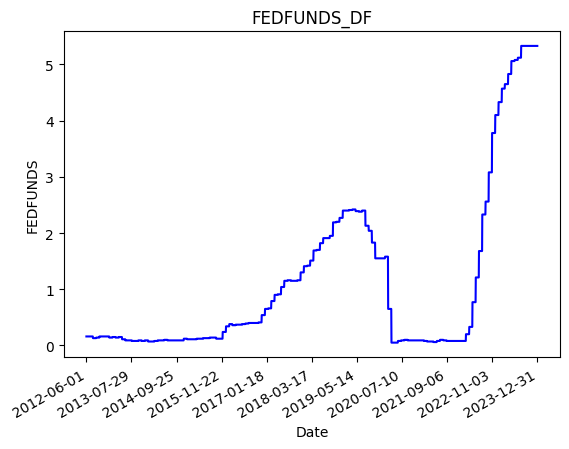

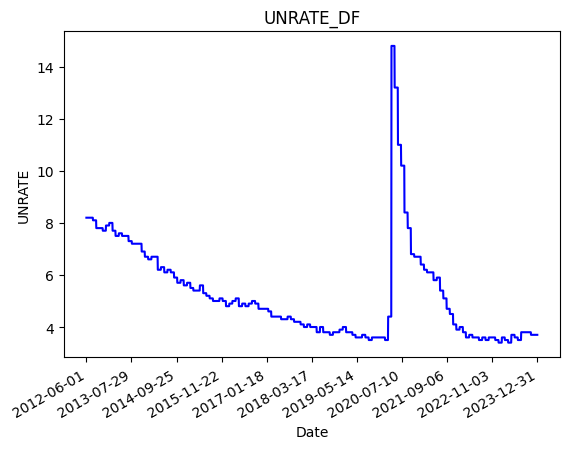

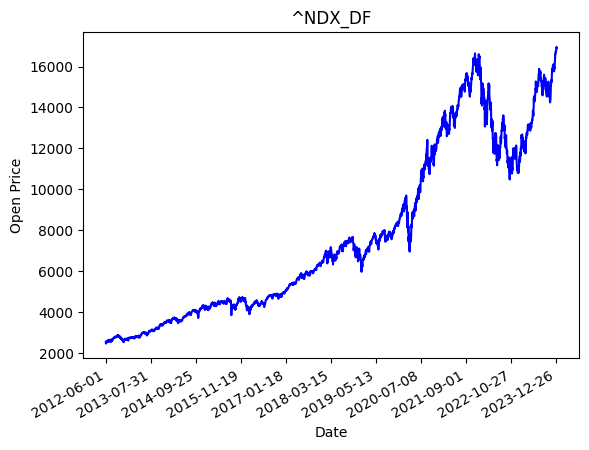

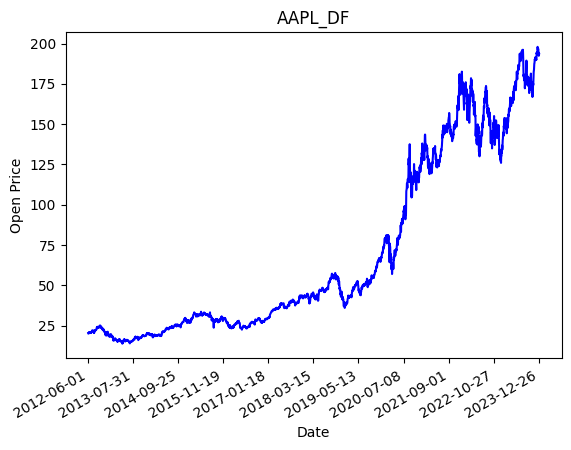

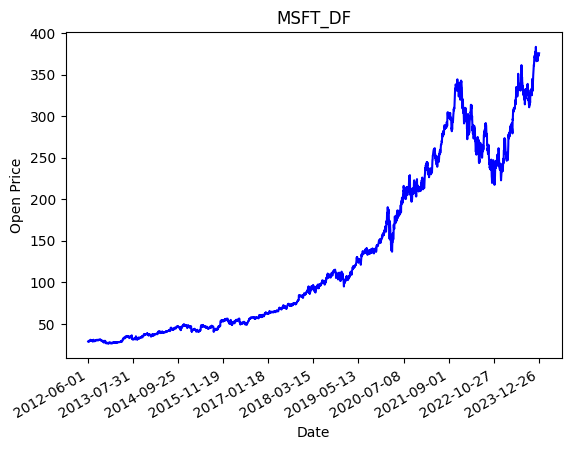

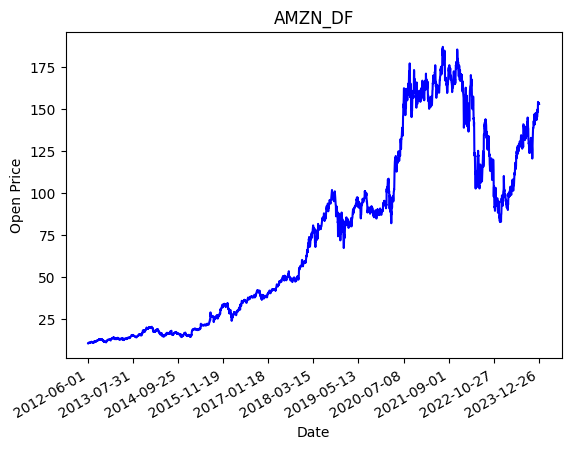

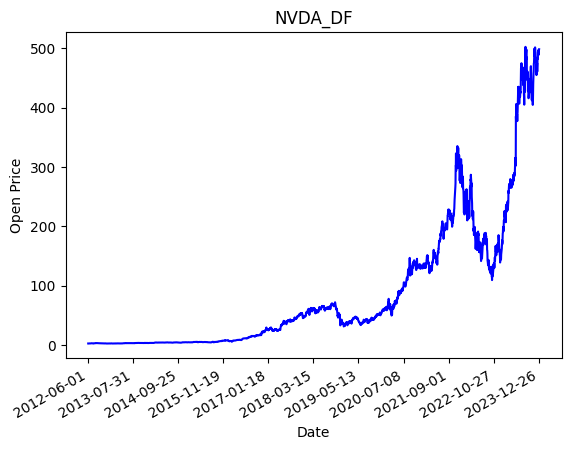

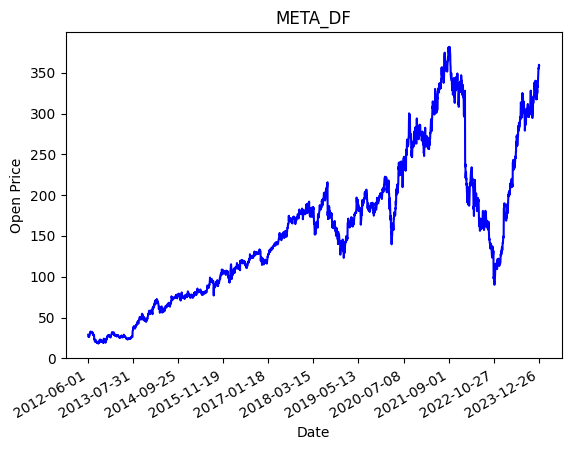

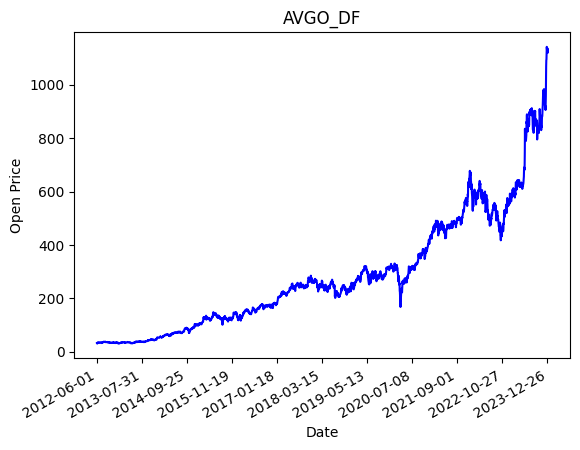

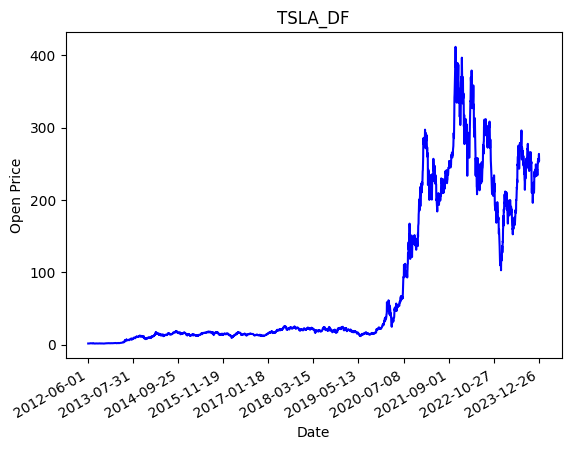

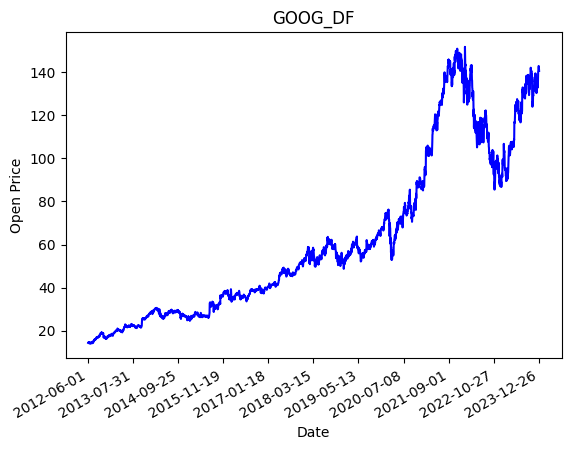

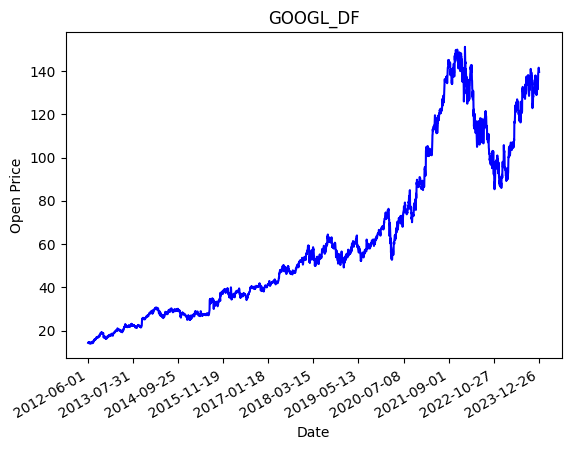

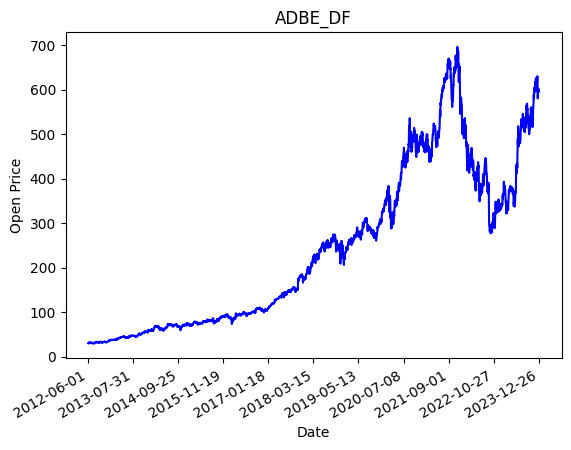

In [77]:
# Graficaremos cada variable
num_ticks = 10

for df in stocks_dict.keys():
    if df in macros:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], linestyle= '-', color='b')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1])

    if df in stocks:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], label= 'Open Price', linestyle= '-', color='b')
        #ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,2], label= 'Close Price', linestyle= '--', color='r')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1] + ' Price')

plt.show()

Las gráficas anteriores indican que no existen valores atípicos en la variable seleccionada.

**Análisis de cardinalidad.**

Si buscamos determinar la cardinalidad de las variables, podemos afirmar que no hay variables categóricas para analizar. Sin embargo, incluso al intentar analizar la cardinalidad de las variables no categóricas, podemos utilizar las gráficas anteriores para observar que varía de manera diferente en cada empresa, pero en general tiende a ser alta cuando consideramos un plazo de tiempo también extenso.

**Tendencias temporales**

Con base en las gráficas anteriores, también es posible identificar tendencias temporales, las cuales son comunes en este tipo de variables a lo largo del tiempo. Se observa que prácticamente todas las empresas muestran tendencias temporales, como el ejemplo de Amazon, donde se aprecia un crecimiento significativo durante el 2020 y una estabilidad relativa hasta el 2022.

**A continuación, realizaremos un análisis de distribución para cada variable numérica de los dataframes. Este análisis nos permitirá identificar si las variables tienen una distribución normal o si están sesgadas.**

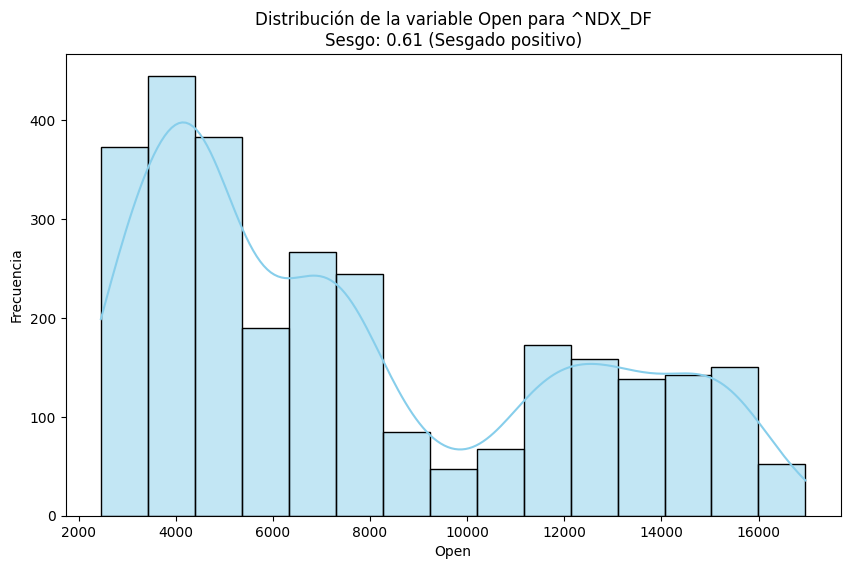

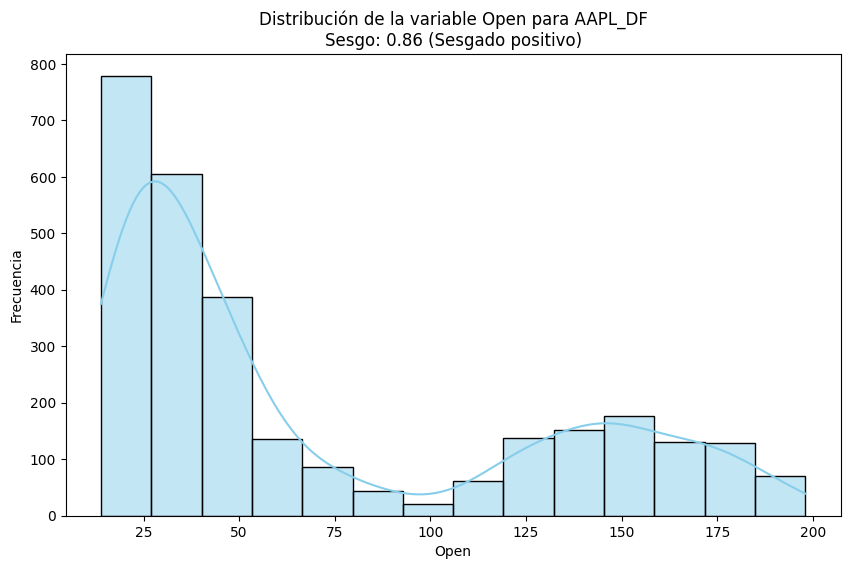

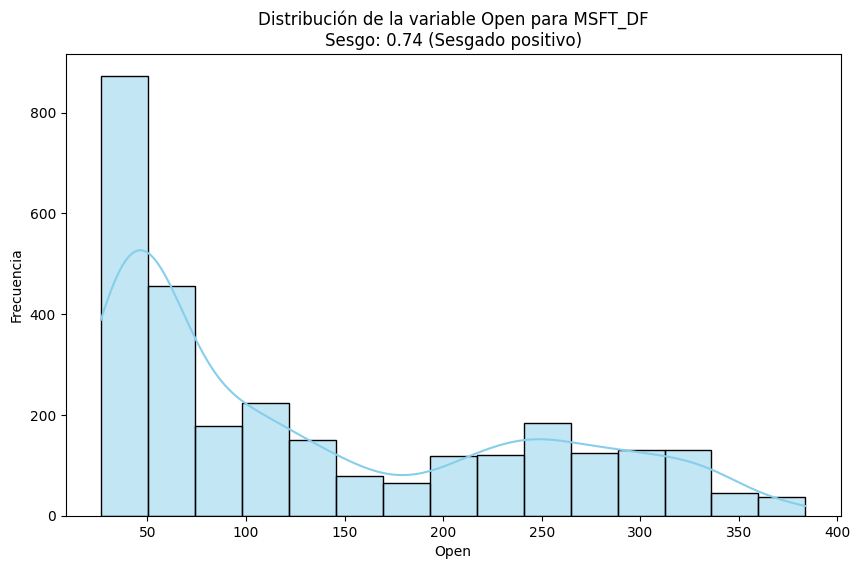

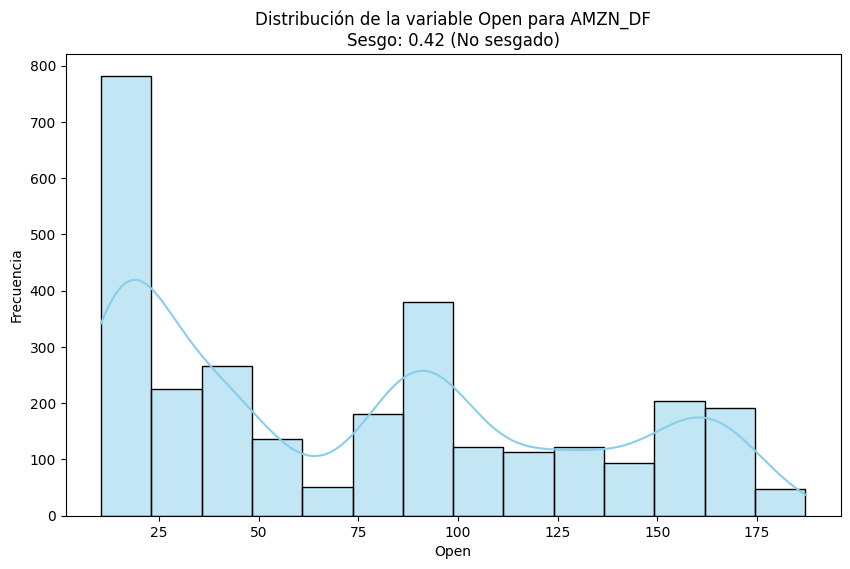

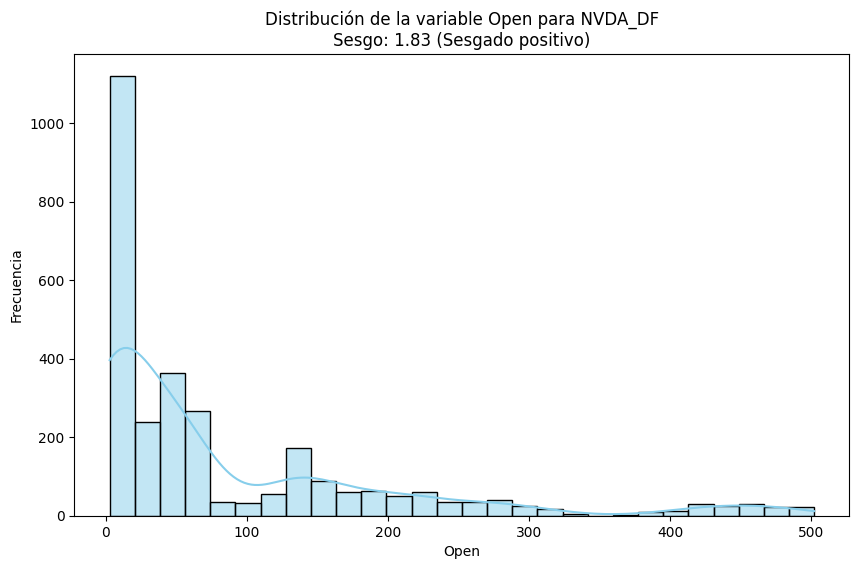

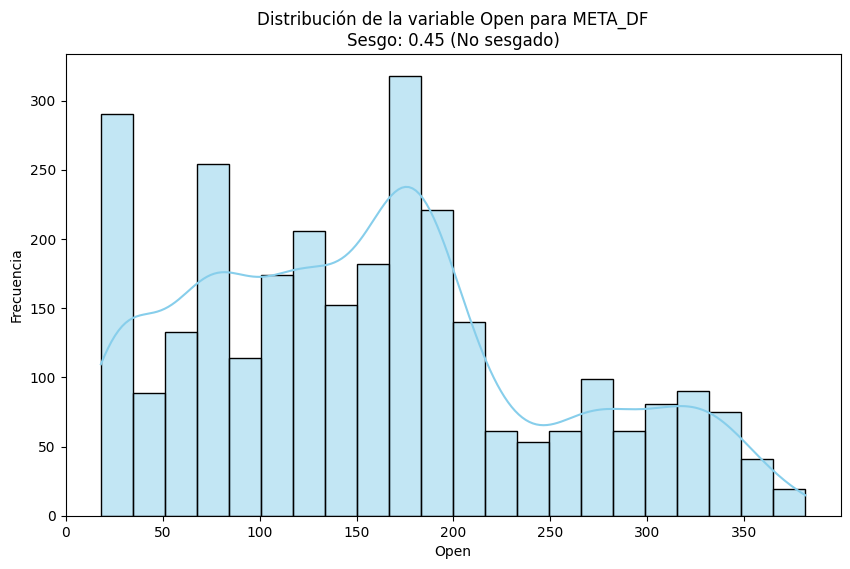

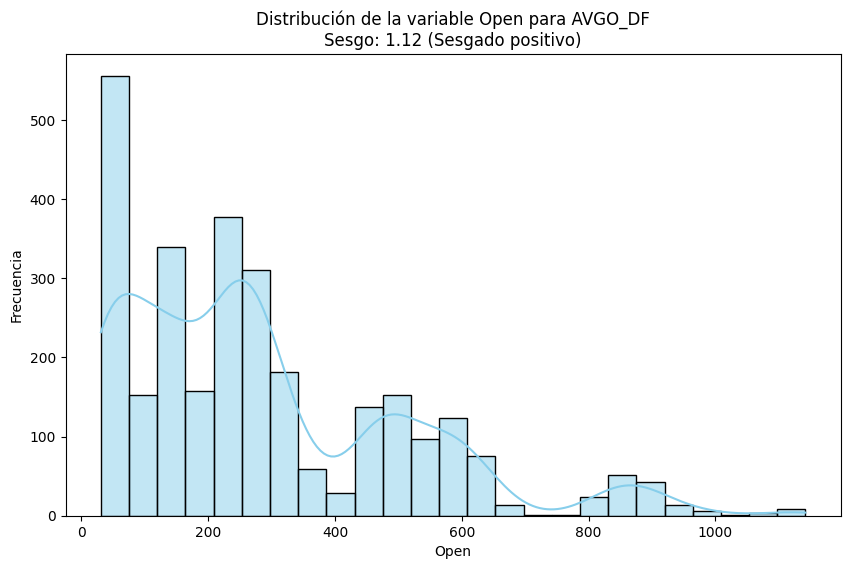

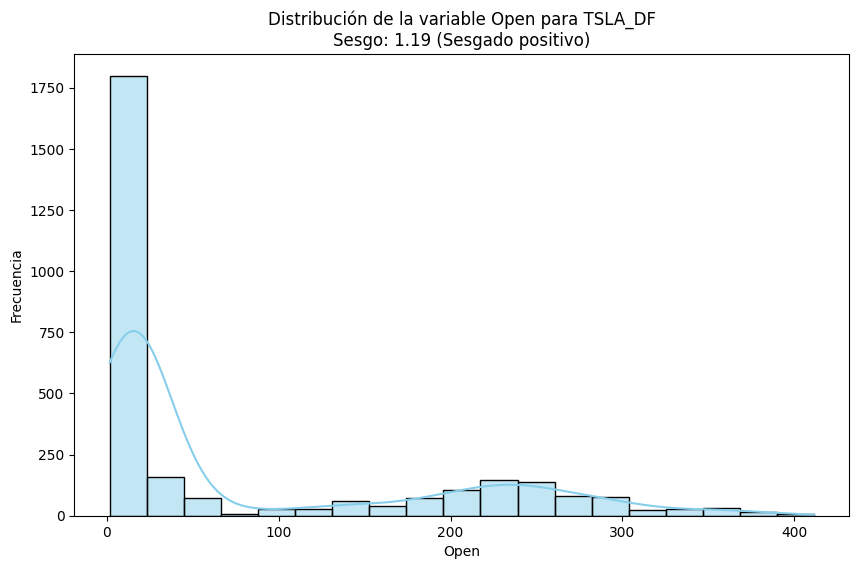

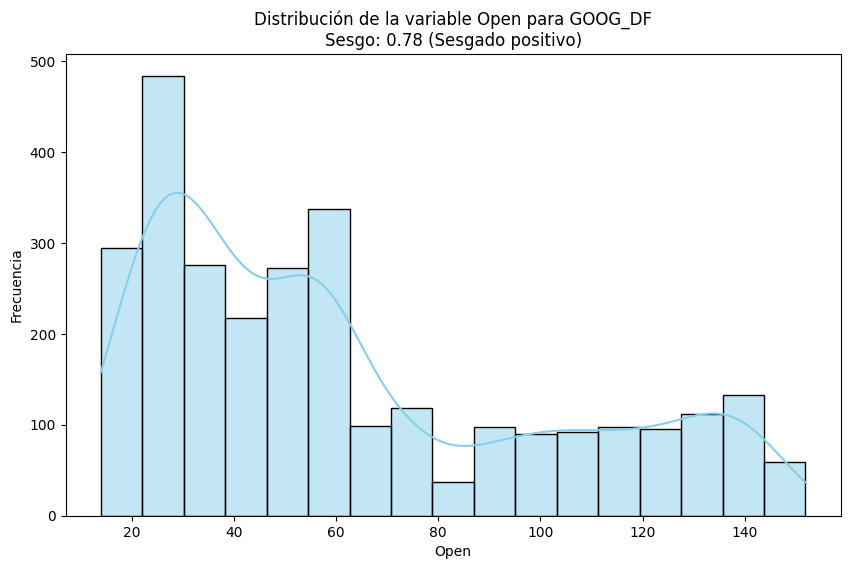

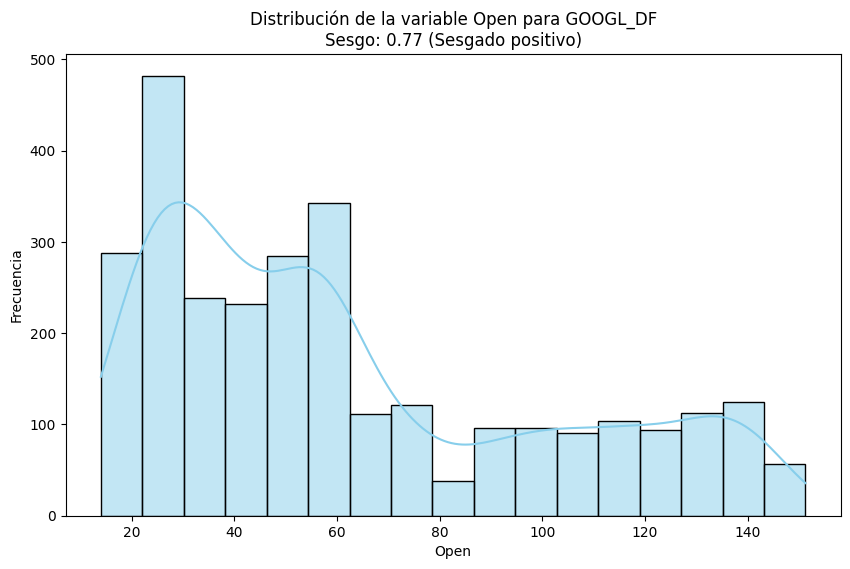

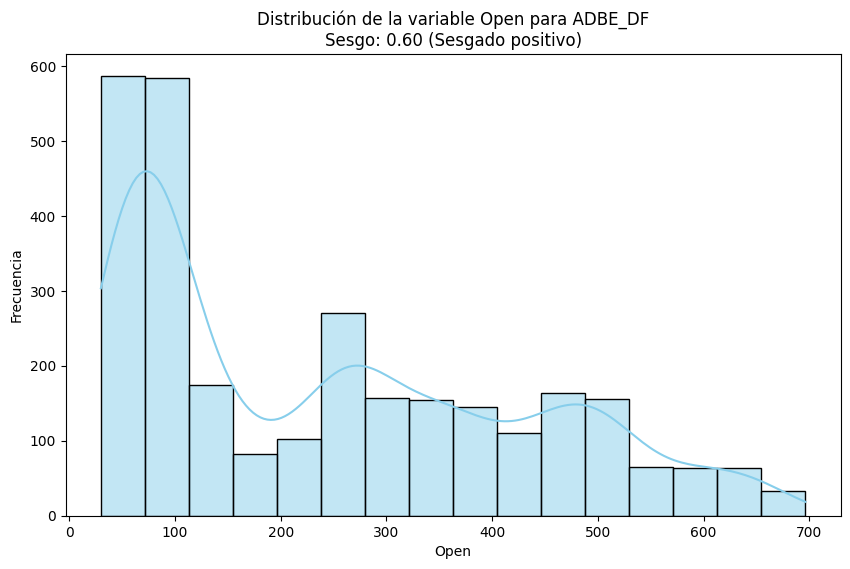

In [78]:
import seaborn as sns
from scipy.stats import skew

for df in stocks_dict.keys():
  if df in stocks:

    sesgo = skew(stocks_dict[df]['Open'])

    if abs(sesgo) > 0.5:
        tipo_sesgo = "Sesgado positivo"
    elif abs(sesgo) < -0.5:
      tipo_sesgo = "Sesgado negativo"
    else:
        tipo_sesgo = "No sesgado"

    plt.figure(figsize=(10, 6))
    sns.histplot(stocks_dict[df]['Open'], kde=True, color='skyblue')
    plt.title(f'Distribución de la variable Open para {df}\nSesgo: {sesgo:.2f} ({tipo_sesgo})')
    plt.xlabel('Open')
    plt.ylabel('Frecuencia')
    plt.show()



Analizando los resultados, observamos que la mayoría de las variables presentan un sesgo positivo, mientras que una minoría no muestra sesgo alguno.

Por el momento no estaremos realizando transformaciones no lineales a los datos, mas bien buscaremos primero implementar modelos que no usen este requisito, aunque no se descarta que en un futuro se regrese a explorar esta posibilidad para mejorar los modelos

**Análisis de las variables dependientes e independientes.**

A continuación se hará un análisis de correlación sobre las variables identificadas:

In [79]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
for i in stocks:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])

<ipython-input-79-de58e0b36a8b>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])
<ipython-input-79-de58e0b36a8b>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])
<ipython-input-79-de58e0b36a8b>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals`

In [80]:
# Para cada dataframe, asignamos como índice la columna de la fecha
for df in stocks_dict.keys():
#    if df in stocks:
        stocks_dict[df].set_index('Date', inplace= True)
        stocks_dict[df].columns = [f'{df}_{col}' for col in stocks_dict[df].columns]

stocks_dict['AAPL_DF']

,AAPL_DF_Open,AAPL_DF_Close,AAPL_DF_Volume
Date,,,
2012-06-01,20.327143,20.035357,520987600
2012-06-04,20.053572,20.153214,556995600
2012-06-05,20.045357,20.101070,388214400
2012-06-06,20.277500,20.409286,401455600
2012-06-07,20.617500,20.418571,379766800
...,...,...,...
2023-12-22,195.179993,193.600006,37122800
2023-12-26,193.610001,193.050003,28919300
2023-12-27,192.490005,193.149994,48087700


In [81]:
# Unimos los dataframes con la fecha como índice
first_key = next(iter(stocks_dict))
first_key

for df in stocks_dict.keys():
    if df == first_key:
        merged_stocks = stocks_dict[df]
    else:
        merged_stocks = pd.merge(merged_stocks, stocks_dict[df], how='left', left_index=True, right_index=True)

#merged_stocks.set_index('Date', inplace= True)
merged_stocks

,FEDFUNDS_DF_FEDFUNDS,UNRATE_DF_UNRATE,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,AAPL_DF_Open,AAPL_DF_Close,AAPL_DF_Volume,MSFT_DF_Open,MSFT_DF_Close,...,TSLA_DF_Volume,GOOG_DF_Open,GOOG_DF_Close,GOOG_DF_Volume,GOOGL_DF_Open,GOOGL_DF_Close,GOOGL_DF_Volume,ADBE_DF_Open,ADBE_DF_Close,ADBE_DF_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-01,0.16,8.2,2510.820068,2458.830078,1.966370e+09,20.327143,20.035357,520987600.0,28.760000,28.450001,...,13287000.0,14.241370,14.221195,122774470.0,14.309059,14.288789,122193684.0,30.370001,29.820000,4362000.0
2012-06-02,0.16,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-03,0.16,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-04,0.16,8.2,2458.969971,2478.129883,1.755750e+09,20.053572,20.153214,556995600.0,28.620001,28.549999,...,15463500.0,14.202266,14.410735,97672734.0,14.269770,14.479229,97210692.0,29.879999,30.309999,3668100.0
2012-06-05,0.16,8.2,2467.810059,2487.500000,1.625600e+09,20.045357,20.101070,388214400.0,28.510000,28.510000,...,9463500.0,14.332528,14.206999,93946821.0,14.400651,14.274525,93502404.0,30.190001,30.709999,2263800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,5.33,3.7,16896.140625,16906.800781,7.480170e+09,192.490005,193.149994,48087700.0,373.690002,374.070007,...,106494400.0,142.830002,141.440002,17288400.0,141.589996,140.369995,19628600.0,598.599976,596.080017,1394900.0
2023-12-28,5.33,3.7,16963.519531,16898.470703,5.090570e+09,194.139999,193.580002,34049900.0,375.369995,375.279999,...,113619900.0,141.850006,141.279999,12192500.0,140.779999,140.229996,16045700.0,597.440002,595.520020,1702600.0
2023-12-29,5.33,3.7,16902.439453,16825.929688,5.441060e+09,193.899994,192.529999,42628800.0,376.000000,376.040009,...,100615300.0,140.679993,140.929993,14872700.0,139.630005,139.690002,18727200.0,596.090027,596.599976,1893900.0


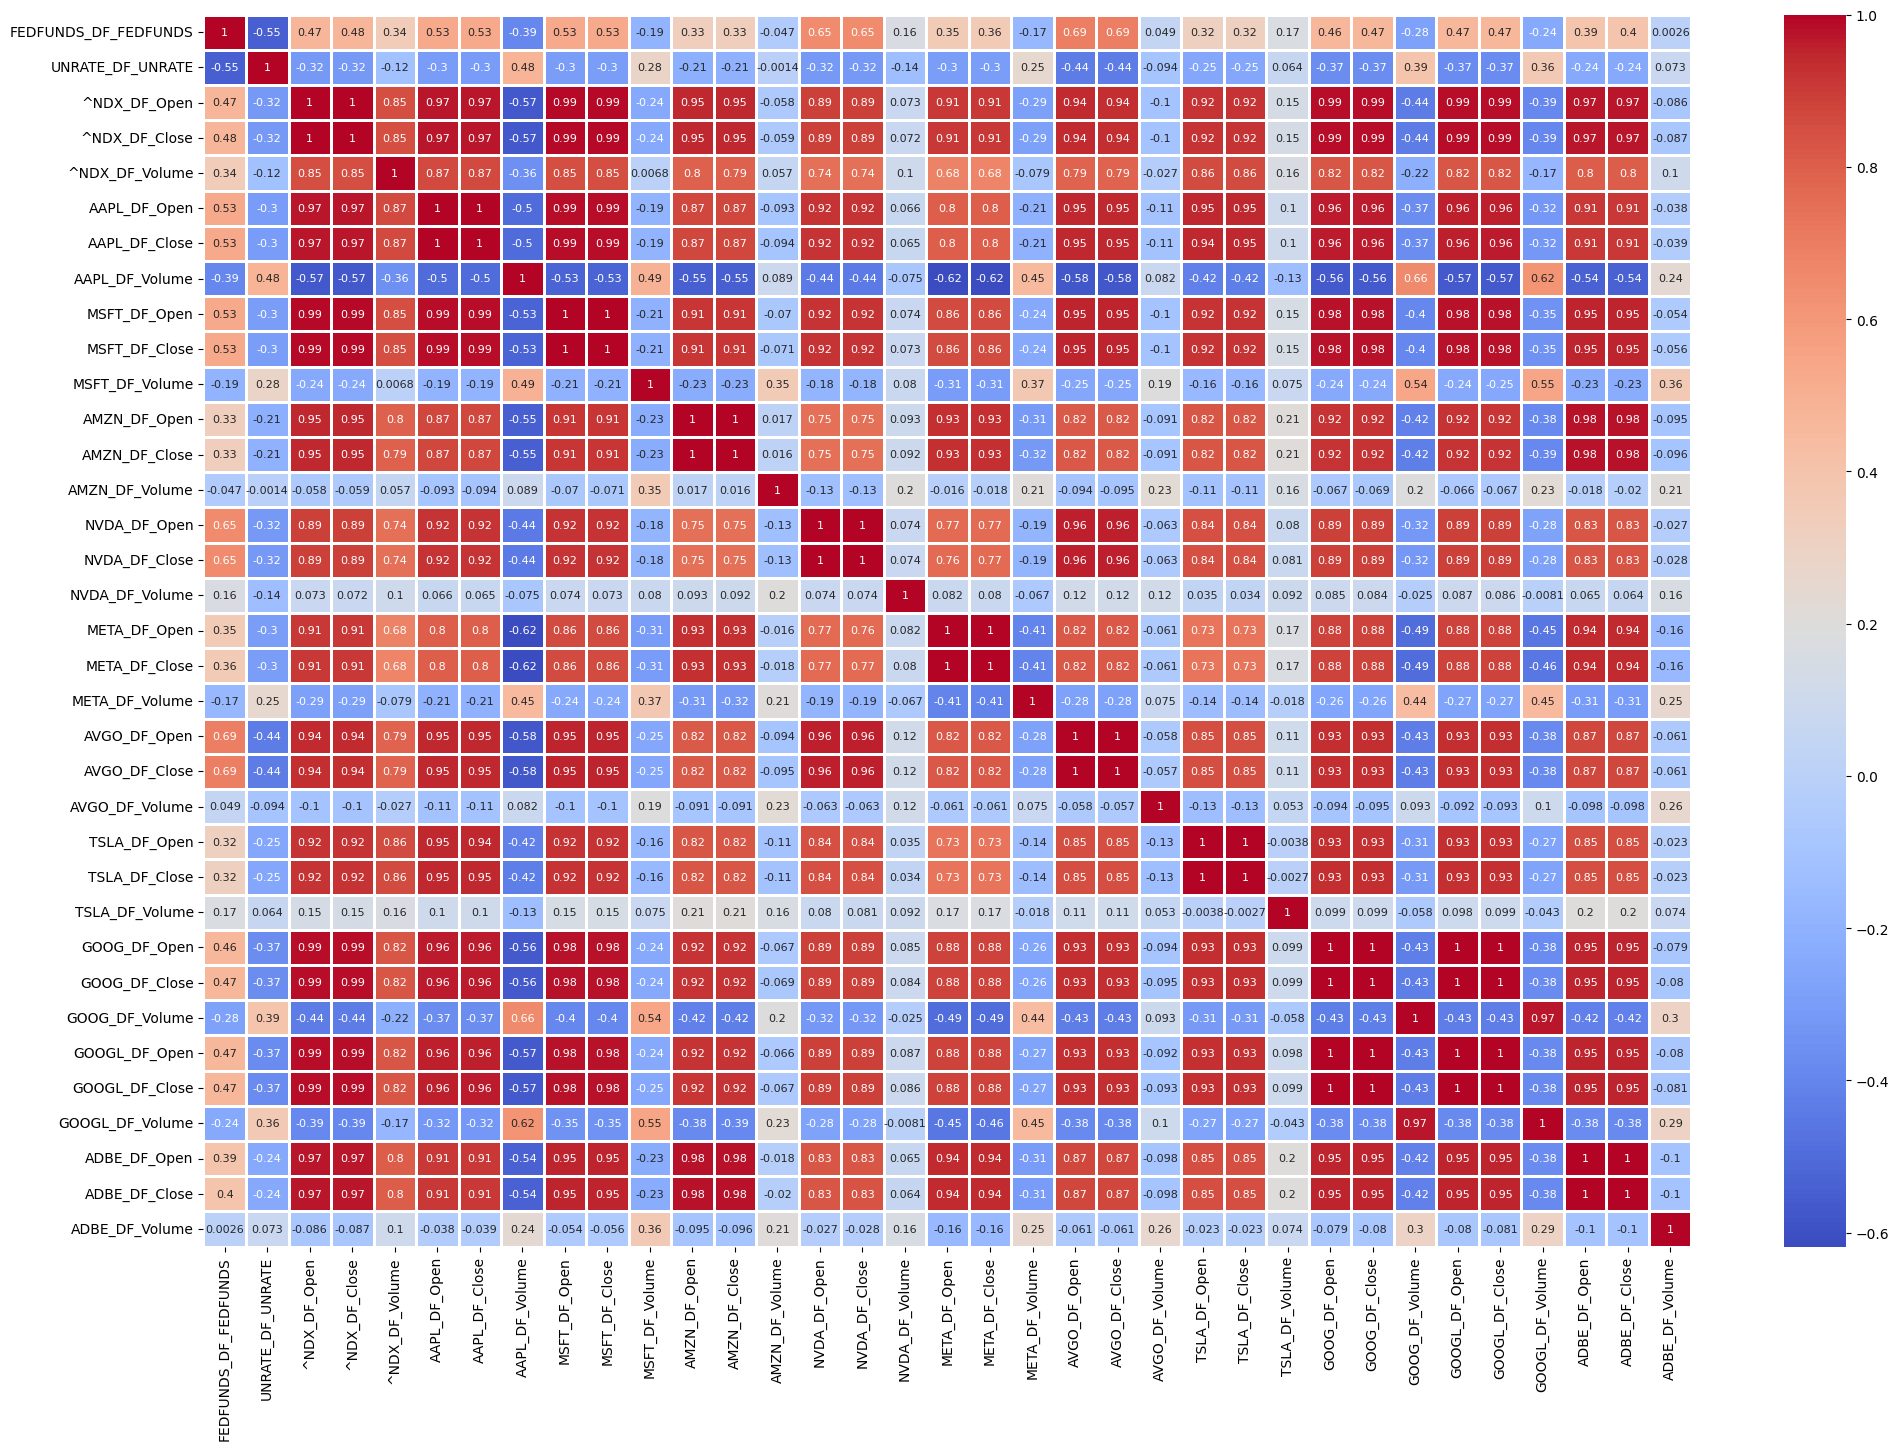

In [82]:
#Calculamos la correlación entre las variables
plt.figure(figsize=(24,16))
sns.heatmap(merged_stocks.corr(), cmap='coolwarm', linewidths = 1, annot=True, annot_kws={"fontsize":8})
plt.show()

Como resultado del análisis se puede observar que las variables de volumen de operación son las que tienen menos correlación contra todas las demas, seguidas de las variables macroeconómicas de la tasa de interés y tasa de desempleo. Finalmente en rojo se aprecian que en general los precios de apertura y cierre de una misma acción tienen una alta correlación mientras también una correlación (un poco más debil) contra precios de otras acciones.

**Distribución de los datos por categorías.**

Al no disponer de variables categóricas, no es posible identificar distribuciones en los datos de manera convencional.

**Patrones o agrupaciones (clusters) de datos.**

La tendencia de los datos utilizados sugiere que no existen patrones o agrupaciones discernibles en este conjunto.

**Normalización de imágenes.**

Para este proyecto no es necesario el uso de imágenes.

**¿Hay desequilibrio en las clases de la variable objetivo?**

Por el momento no se ha definido formalmente una variable objetivo, se pretende realizar la predicción del ^NDX_DF_Open, que representa el precio de apertura del índice bursatil, en el presente análisis todavía se presenta como un valor numérico. Sin embargo en futuras entregas se pretende evaluar si es más conveniente convertirlo en una variable categórica que represente si al día t+1 aumentó o disminuyó su valor respecto al cierre del día t. Esto considerando el objetivo de tener una estrategia de inversión que nos permite identificar qué es más conveniente, si mantener el ETF o venderlo a final de día.

# Ingeniería de características (FE - Feature Engineering)

**Construcción**

Ahora incorporamos una nueva característica a cada conjunto de datos: la variación diaria entre la apertura y el cierre del mercado, con el objetivo de analizar y visualizar esta tendencia.

 La variación diaria entre la apertura y el cierre del mercado es una métrica relevante que puede enriquecer la información disponible para el modelo de predicción de acciones, ofreciendo una perspectiva más detallada sobre la dinámica diaria del mercado de valores.

In [83]:
for df in stocks_dict.keys():

  if df in stocks:
    open_columns = [col for col in stocks_dict[df].columns if col.endswith("Open")]
    close_columns = [col for col in stocks_dict[df].columns if col.endswith("Close")]

    if open_columns and close_columns:
      open_column = open_columns[0]
      close_column = close_columns[0]
      stocks_dict[df][df + '_DailyVar'] = stocks_dict[df][close_column] - stocks_dict[df][open_column]

In [84]:
#Mostramos que la nueva columna se ha creado correctamente
stocks_dict['TSLA_DF']

,TSLA_DF_Open,TSLA_DF_Close,TSLA_DF_Volume,TSLA_DF_DailyVar
Date,,,,
2012-06-01,1.902000,1.876667,13287000,-0.025333
2012-06-04,1.868667,1.858667,15463500,-0.010000
2012-06-05,1.856000,1.860667,9463500,0.004667
2012-06-06,1.880000,1.948000,13648500,0.068000
2012-06-07,1.987333,1.928667,7381500,-0.058666
...,...,...,...,...
2023-12-22,256.760010,252.539993,93249800,-4.220017
2023-12-26,254.490005,256.609985,86892400,2.119980
2023-12-27,258.350006,261.440002,106494400,3.089996


Sobre los dataframes que teniamos (previo a unirlos) vamos a buscar en específico el de ^NDX_DF. Este dataframe contiene en específico el índice bursatil que deseamos predecir. Lo que haremos será agregar una nueva columna que nos indique el precio del día siguiente, posteriormente haremos una comparación entre el precio de cierre y el precio del día siguiente y, con el resultado de la comparación, definiremos la variable objetivo binaria que nos dice si el precio subió o bajó.


In [85]:
# Insertamos columna con el precio de apertura del día siguiente
stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] = stocks_dict['^NDX_DF']['^NDX_DF_Open'].shift(-1)

# Insertamos columna binaria que indica si subió o bajó el precio
stocks_dict['^NDX_DF']['^NDX_DF_Target'] = (stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] > stocks_dict['^NDX_DF']['^NDX_DF_Close']).astype(int)
stocks_dict['^NDX_DF']


,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,^NDX_DF_DailyVar,^NDX_DF_Tomorrow,^NDX_DF_Target
Date,,,,,,
2012-06-01,2510.820068,2458.830078,1966370000,-51.989990,2458.969971,1
2012-06-04,2458.969971,2478.129883,1755750000,19.159912,2467.810059,0
2012-06-05,2467.810059,2487.500000,1625600000,19.689941,2504.080078,1
2012-06-06,2504.080078,2546.320068,1761050000,42.239990,2569.239990,1
2012-06-07,2569.239990,2535.409912,1655370000,-33.830078,2529.419922,0
...,...,...,...,...,...,...
2023-12-22,16799.019531,16777.400391,4796600000,-21.619140,16816.779297,1
2023-12-26,16816.779297,16878.460938,6120600000,61.681641,16896.140625,1
2023-12-27,16896.140625,16906.800781,7480170000,10.660156,16963.519531,1


In [86]:
# Añadiremos información sobre tendencias y razones a través de cierto números de dias
# Definimos los dias de tendencia hacia atrás que deseamos revisar
horizons = [5, 10, 20, 60, 120, 240, 480]

# Calculamos el promedio móvil para cada horizonte
for h in horizons:
    prom_m = stocks_dict['^NDX_DF'].rolling(h).mean()

    close_ratio = f'^NDX_DF_CloseR_{h}'
    stocks_dict['^NDX_DF'][close_ratio] = stocks_dict['^NDX_DF']['^NDX_DF_Close'] / prom_m['^NDX_DF_Close']

    trend_ratio = f'^NDX_DF_Trend_{h}'
    stocks_dict['^NDX_DF'][trend_ratio] = stocks_dict['^NDX_DF'].shift(1).rolling(h).sum()['^NDX_DF_Target']

stocks_dict['^NDX_DF']

,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,^NDX_DF_DailyVar,^NDX_DF_Tomorrow,^NDX_DF_Target,^NDX_DF_CloseR_5,^NDX_DF_Trend_5,^NDX_DF_CloseR_10,^NDX_DF_Trend_10,^NDX_DF_CloseR_20,^NDX_DF_Trend_20,^NDX_DF_CloseR_60,^NDX_DF_Trend_60,^NDX_DF_CloseR_120,^NDX_DF_Trend_120,^NDX_DF_CloseR_240,^NDX_DF_Trend_240,^NDX_DF_CloseR_480,^NDX_DF_Trend_480
Date,,,,,,,,,,,,,,,,,,,,
2012-06-01,2510.820068,2458.830078,1966370000,-51.989990,2458.969971,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-04,2458.969971,2478.129883,1755750000,19.159912,2467.810059,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-05,2467.810059,2487.500000,1625600000,19.689941,2504.080078,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-06,2504.080078,2546.320068,1761050000,42.239990,2569.239990,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-07,2569.239990,2535.409912,1655370000,-33.830078,2529.419922,0,1.013662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,16799.019531,16777.400391,4796600000,-21.619140,16816.779297,1,1.003066,4.0,1.011112,7.0,1.031033,11.0,1.083757,36.0,1.092555,69.0,1.179138,129.0,1.254290,239.0
2023-12-26,16816.779297,16878.460938,6120600000,61.681641,16896.140625,1,1.007317,4.0,1.013192,8.0,1.034331,12.0,1.087751,36.0,1.098070,70.0,1.184341,129.0,1.261281,239.0
2023-12-27,16896.140625,16906.800781,7480170000,10.660156,16963.519531,1,1.007866,4.0,1.011538,9.0,1.033230,13.0,1.087162,36.0,1.098800,71.0,1.184444,129.0,1.262916,239.0


In [87]:
# Generamos nuevamente nuestro dataframe con toda la información junta
# Unimos los dataframes con la fecha como índice
first_key = next(iter(stocks_dict))
first_key

for df in stocks_dict.keys():
    if df == first_key:
        X = stocks_dict[df]
    else:
        X = pd.merge(X, stocks_dict[df], how='left', left_index=True, right_index=True)


# Quitamos las filas donde no habia suficiente información para calcular y tenemos NaN
X = X.dropna()
X

,FEDFUNDS_DF_FEDFUNDS,UNRATE_DF_UNRATE,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,^NDX_DF_DailyVar,^NDX_DF_Tomorrow,^NDX_DF_Target,^NDX_DF_CloseR_5,^NDX_DF_Trend_5,...,GOOG_DF_Volume,GOOG_DF_DailyVar,GOOGL_DF_Open,GOOGL_DF_Close,GOOGL_DF_Volume,GOOGL_DF_DailyVar,ADBE_DF_Open,ADBE_DF_Close,ADBE_DF_Volume,ADBE_DF_DailyVar
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-01,0.09,6.3,3589.659912,3594.360107,2.077040e+09,4.700195,3608.840088,1.0,1.008038,3.0,...,38110345.0,0.211420,26.712500,26.926500,40086000.0,0.214000,61.689999,62.590000,2839300.0,0.900001
2014-05-02,0.09,6.3,3608.840088,3587.639893,1.844790e+09,-21.200195,3566.260010,0.0,1.003084,4.0,...,33770463.0,-0.290703,27.072001,26.693501,35616000.0,-0.378500,62.860001,61.560001,2365300.0,-1.300000
2014-05-05,0.09,6.3,3566.260010,3605.090088,1.561170e+09,38.830078,3598.270020,0.0,1.004590,3.0,...,20482080.0,0.149090,26.511999,26.766500,24568000.0,0.254501,61.200001,61.439999,2070200.0,0.239998
2014-05-06,0.09,6.3,3598.270020,3556.510010,1.850610e+09,-41.760010,3561.469971,1.0,0.992019,2.0,...,33780490.0,-0.503118,26.670500,26.128500,36700000.0,-0.542000,61.150002,59.439999,3913200.0,-1.710003
2014-05-07,0.09,6.3,3561.469971,3546.469971,2.486030e+09,-15.000000,3533.389893,0.0,0.991184,3.0,...,64486563.0,-0.290703,26.162500,25.900000,61486000.0,-0.262500,59.560001,58.630001,7061100.0,-0.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,5.33,3.7,16719.609375,16757.410156,5.465640e+09,37.800781,16799.019531,1.0,1.003718,4.0,...,18101500.0,1.029999,139.490005,140.419998,27488300.0,0.929993,603.000000,600.140015,3192800.0,-2.859985
2023-12-22,5.33,3.7,16799.019531,16777.400391,4.796600e+09,-21.619140,16816.779297,1.0,1.003066,4.0,...,18494700.0,0.589996,140.770004,141.490005,26514600.0,0.720001,600.799988,598.750000,1659800.0,-2.049988
2023-12-26,5.33,3.7,16816.779297,16878.460938,6.120600e+09,61.681641,16896.140625,1.0,1.007317,4.0,...,11170100.0,-0.159989,141.589996,141.520004,16780300.0,-0.069992,598.919983,598.260010,1595100.0,-0.659973


In [88]:
# Separamos nuestros dataframe en variables independientes (X) y dependientes/objetivo (Y)
Y = X.pop('^NDX_DF_Target').to_frame().astype(int)
Y

,^NDX_DF_Target
Date,
2014-05-01,1
2014-05-02,0
2014-05-05,0
2014-05-06,1
2014-05-07,0
...,...
2023-12-21,1
2023-12-22,1
2023-12-26,1


**Normalización**
Se utilizará un escalado basado en MinMax con la finalidad de evitar que los rangos de ciertas variables tengan mayor peso que otras.

In [89]:
# Importamos librerias
from sklearn.preprocessing import MinMaxScaler

# Inicializamos el escalador
scaler = MinMaxScaler()

# Transformamos la data con el escalador
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns= X.columns, index= X.index)

X_scaled

,FEDFUNDS_DF_FEDFUNDS,UNRATE_DF_UNRATE,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,^NDX_DF_DailyVar,^NDX_DF_Tomorrow,^NDX_DF_CloseR_5,^NDX_DF_Trend_5,^NDX_DF_CloseR_10,...,GOOG_DF_Volume,GOOG_DF_DailyVar,GOOGL_DF_Open,GOOGL_DF_Close,GOOGL_DF_Volume,GOOGL_DF_DailyVar,ADBE_DF_Open,ADBE_DF_Close,ADBE_DF_Volume,ADBE_DF_DailyVar
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-01,0.007576,0.254386,0.004190,0.004036,0.161107,0.373326,0.005618,0.626071,0.6,0.652030,...,0.144084,0.474539,0.013861,0.016590,0.124164,0.476899,0.005251,0.006288,0.082569,0.489285
2014-05-02,0.007576,0.254386,0.005618,0.003533,0.140693,0.355381,0.002447,0.595906,0.8,0.636826,...,0.124026,0.439180,0.016708,0.014726,0.106129,0.435703,0.007085,0.004653,0.065176,0.463940
2014-05-05,0.007576,0.254386,0.002447,0.004838,0.115764,0.396971,0.004831,0.605072,0.6,0.653070,...,0.062608,0.470149,0.012274,0.015310,0.061553,0.479715,0.004483,0.004462,0.054347,0.481682
2014-05-06,0.007576,0.254386,0.004831,0.001204,0.141204,0.341137,0.002091,0.528518,0.4,0.596017,...,0.124072,0.424222,0.013529,0.010205,0.110502,0.424335,0.004405,0.001286,0.121977,0.459216
2014-05-07,0.007576,0.254386,0.002091,0.000453,0.197055,0.359677,0.000000,0.523434,0.6,0.584700,...,0.265992,0.439180,0.009506,0.008377,0.210506,0.443769,0.001912,0.000000,0.237492,0.468202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,1.000000,0.026316,0.981839,0.988823,0.458951,0.396258,0.987751,0.599766,0.8,0.679839,...,0.051606,0.532181,0.906880,0.924643,0.073336,0.526682,0.853779,0.859895,0.095541,0.445968
2023-12-22,1.000000,0.026316,0.987751,0.990319,0.400145,0.355091,0.989074,0.595792,0.8,0.666217,...,0.053423,0.501197,0.917015,0.933204,0.069407,0.512081,0.850331,0.857687,0.039287,0.455299
2023-12-26,1.000000,0.026316,0.989074,0.997880,0.516520,0.412803,0.994983,0.621682,0.8,0.675573,...,0.019570,0.448385,0.923508,0.933444,0.030132,0.457154,0.847384,0.856909,0.036912,0.471313


**Selección / Extracción**

Umbral de Varianza

Con esto realizamos una selección de características que sirve para identificar las variables importantes en su defecto identificar las características cuya varianza no supera un umbral específico. La idea es descartar características que tienen poca variabilidad, ya que pueden no proporcionar mucha información útil para el modelo de machine learning.

In [90]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_scaled)

In [91]:
# Ahora se muestran las caracteristicas que se consideran IMPORTANTES por su lata varianza.
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['FEDFUNDS_DF_FEDFUNDS', 'UNRATE_DF_UNRATE', '^NDX_DF_Open',
       '^NDX_DF_Close', '^NDX_DF_Volume', '^NDX_DF_Tomorrow',
       '^NDX_DF_Trend_5', '^NDX_DF_Trend_10', '^NDX_DF_Trend_20',
       '^NDX_DF_CloseR_60', '^NDX_DF_Trend_60', '^NDX_DF_CloseR_120',
       '^NDX_DF_Trend_120', '^NDX_DF_CloseR_240', '^NDX_DF_Trend_240',
       '^NDX_DF_CloseR_480', '^NDX_DF_Trend_480', 'AAPL_DF_Open',
       'AAPL_DF_Close', 'AAPL_DF_Volume', 'MSFT_DF_Open', 'MSFT_DF_Close',
       'AMZN_DF_Open', 'AMZN_DF_Close', 'NVDA_DF_Open', 'NVDA_DF_Close',
       'META_DF_Open', 'META_DF_Close', 'AVGO_DF_Open', 'AVGO_DF_Close',
       'TSLA_DF_Open', 'TSLA_DF_Close', 'GOOG_DF_Open', 'GOOG_DF_Close',
       'GOOGL_DF_Open', 'GOOGL_DF_Close', 'ADBE_DF_Open', 'ADBE_DF_Close'],
      dtype='object')


Con esta información, se podría considerar la posibilidad de eliminar el resto de las características. Observamos que la recién agregada variable "DailyVar" no está presente debido a su baja variabilidad, lo que sugiere que existe una media de crecimiento o decrecimiento y no aporta un valor significativo. Otra opcion es realiza una transformación adicional a la variable "DailyVariation" para aumentar su variabilidad antes de aplicar el umbral de varianza.

In [92]:
columns_to_square = [col for col in X_scaled.columns if col.endswith('_DailyVar')]
X_scaled[columns_to_square] = X_scaled[columns_to_square].apply(lambda x: x**2)

In [93]:
X_selected = selector.fit_transform(X_scaled)

Revisamos de nuevo el umbral de varianza.

In [94]:
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['FEDFUNDS_DF_FEDFUNDS', 'UNRATE_DF_UNRATE', '^NDX_DF_Open',
       '^NDX_DF_Close', '^NDX_DF_Volume', '^NDX_DF_Tomorrow',
       '^NDX_DF_Trend_5', '^NDX_DF_Trend_10', '^NDX_DF_Trend_20',
       '^NDX_DF_CloseR_60', '^NDX_DF_Trend_60', '^NDX_DF_CloseR_120',
       '^NDX_DF_Trend_120', '^NDX_DF_CloseR_240', '^NDX_DF_Trend_240',
       '^NDX_DF_CloseR_480', '^NDX_DF_Trend_480', 'AAPL_DF_Open',
       'AAPL_DF_Close', 'AAPL_DF_Volume', 'MSFT_DF_Open', 'MSFT_DF_Close',
       'AMZN_DF_Open', 'AMZN_DF_Close', 'NVDA_DF_Open', 'NVDA_DF_Close',
       'META_DF_Open', 'META_DF_Close', 'AVGO_DF_Open', 'AVGO_DF_Close',
       'TSLA_DF_Open', 'TSLA_DF_Close', 'GOOG_DF_Open', 'GOOG_DF_Close',
       'GOOGL_DF_Open', 'GOOGL_DF_Close', 'ADBE_DF_Open', 'ADBE_DF_Close'],
      dtype='object')


No se obtuvieron mejores resultados por lo que la mejor opción es eliminar esta caracteristica.

In [95]:
#Se elimina la columna de "variación diaria" (_DailyVar)
X_scaled = X_scaled.drop(columns=[col for col in X_scaled.columns if col.endswith('_DailyVar')])
X_scaled

,FEDFUNDS_DF_FEDFUNDS,UNRATE_DF_UNRATE,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,^NDX_DF_Tomorrow,^NDX_DF_CloseR_5,^NDX_DF_Trend_5,^NDX_DF_CloseR_10,^NDX_DF_Trend_10,...,TSLA_DF_Volume,GOOG_DF_Open,GOOG_DF_Close,GOOG_DF_Volume,GOOGL_DF_Open,GOOGL_DF_Close,GOOGL_DF_Volume,ADBE_DF_Open,ADBE_DF_Close,ADBE_DF_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-01,0.007576,0.254386,0.004190,0.004036,0.161107,0.005618,0.626071,0.6,0.652030,0.555556,...,0.078563,0.012725,0.015337,0.144084,0.013861,0.016590,0.124164,0.005251,0.006288,0.082569
2014-05-02,0.007576,0.254386,0.005618,0.003533,0.140693,0.002447,0.595906,0.8,0.636826,0.666667,...,0.056098,0.015331,0.013985,0.124026,0.016708,0.014726,0.106129,0.007085,0.004653,0.065176
2014-05-05,0.007576,0.254386,0.002447,0.004838,0.115764,0.004831,0.605072,0.6,0.653070,0.555556,...,0.073700,0.011827,0.013937,0.062608,0.012274,0.015310,0.061553,0.004483,0.004462,0.054347
2014-05-06,0.007576,0.254386,0.004831,0.001204,0.141204,0.002091,0.528518,0.4,0.596017,0.444444,...,0.081830,0.011988,0.008929,0.124072,0.013529,0.010205,0.110502,0.004405,0.001286,0.121977
2014-05-07,0.007576,0.254386,0.002091,0.000453,0.197055,0.000000,0.523434,0.6,0.584700,0.555556,...,0.157250,0.008287,0.006882,0.265992,0.009506,0.008377,0.210506,0.001912,0.000000,0.237492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,1.000000,0.026316,0.981839,0.988823,0.458951,0.987751,0.599766,0.8,0.679839,0.555556,...,0.109550,0.912786,0.929377,0.051606,0.906880,0.924643,0.073336,0.853779,0.859895,0.095541
2023-12-22,1.000000,0.026316,0.987751,0.990319,0.400145,0.989074,0.595792,0.8,0.666217,0.666667,...,0.091459,0.923478,0.936670,0.053423,0.917015,0.933204,0.069407,0.850331,0.857687,0.039287
2023-12-26,1.000000,0.026316,0.989074,0.997880,0.516520,0.994983,0.621682,0.8,0.675573,0.777778,...,0.084422,0.930160,0.937463,0.019570,0.923508,0.933444,0.030132,0.847384,0.856909,0.036912


Correlación

La correlación existe entre las columnas Open y Close. Lo ideal podria ser generar una nueva caracteritica con esta variable pero en el caso de la variacion diaria, dicha variacion es poca y no representa una variable importante, como ya se analizo anteriormente.

#Conclusiones

General:

En el proceso de desarrollo de nuestro modelo de predicción de valores bursátiles, aplicamos diversas técnicas de ingeniería y selección de características para elevar la calidad de nuestros datos y optimizar el desempeño del modelo.

Características:

La incorporación de nuevas variables, como la "variación diaria", el "precio del día siguiente" e "información sobre tendencias durante varios días", proporciona al modelo datos adicionales sobre la dinámica del mercado, facilitando la captura de patrones temporales y tendencias relevantes.

Normalización:

La normalización y estandarización de las características numéricas aseguran una contribución equitativa de todas las variables al modelo, evitando que las disparidades de escala impacten negativamente el rendimiento del algoritmo. En este contexto, aplicamos normalización al conjunto X.

Umbral de Varianza:

La eliminación de características con baja varianza, como en el caso de "variación diaria" para este conjunto de datos, contribuye a reducir el ruido en el modelo y focalizarse en aquellas características con variabilidad significativa, mejorando así la capacidad de generalización. Dado que la característica "variación diaria" presenta una media de crecimiento y decrecimiento, su aporte al modelo es limitado. Este caso particular destaca la importancia de reconocer que no todas las características que estamos incorporando son realmente útiles.

Correlación:

Suprimir características altamente correlacionadas disminuye la multicolinealidad, mejorando la interpretación del modelo y evitando redundancias que podrían impactar negativamente en el rendimiento del mismo.

A pesar de la correlación existente entre "Open" y "Close", cada uno de estos valores proporciona información única acerca del comportamiento de una acción en una jornada específica. La diferencia entre el precio de cierre y el precio de apertura, conocida como variación diaria, representa una medida valiosa de la actividad del mercado a lo largo del día. Aunque existe una relación entre ambos precios, la variación diaria permite visualizar cómo se ha movido el precio durante la sesión. En el ámbito financiero, tanto el precio de apertura como el precio de cierre son elementos esenciales que inversores y analistas consideran con atención al tomar decisiones.